# Import libraries and set configs

In [1]:
from typing import Union, Tuple 

import sys
sys.path.append("..")

import os
import json
import glob
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

from colorama import Style, Fore

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval

from dotenv import load_dotenv, find_dotenv
# here we load environment variables from .env, must be called before init. class
load_dotenv(find_dotenv('../.env'), verbose=True)

# Set environment variable
environ["ENV"] = "optimize"

tv_username = os.getenv("TV_USERNAME")
tv_password = os.getenv("TV_PASSWORD")

class CFG:
    load = True
    historical = False
    create_dataset = False
    update_dataset = True
    cls_target_ratio_tp = 1.05
    cls_target_ratio_sl = 1.05
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 272
    # for how long time (in hours) we want to predict
    target_offset = 128
    ttype = "both"
    patterns_to_filter = ["STOCH_RSI_Volume24"]
    select_features = False
    optimize = False
    # maximum number of simultaneously opened trades
    max_num_simult_trades = 100
    # significance level, is used to conduct a t-test between 2 models
    optimize_alpha = 0.2 
    n_repeats = 1
    n_folds = 8
    min_precision = 0.575
    last_date = datetime.strptime("2024-09-20:18:00:00", "%Y-%m-%d:%H:%M:%S") # datetime.strptime("2024-10-05:18:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

tqdm.pandas()

warnings.simplefilter(action="ignore", category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "buy"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)



Load the datasets...
ByBitPerpetual
10000000AIDOGEUSDT
1000000BABYDOGEUSDT
1000000MOGUSDT
1000000PEIPEIUSDT
10000COQUSDT
10000LADYSUSDT
10000SATSUSDT
10000WENUSDT
10000WHYUSDT
1000APUUSDT
1000BONKUSDT
1000BTTUSDT
1000CATSUSDT
1000CATUSDT
1000FLOKIUSDT
1000LUNCUSDT
1000MUMUUSDT
1000NEIROCTOUSDT
1000PEPEUSDT
1000RATSUSDT
1000TURBOUSDT
1000XECUSDT
1000XUSDT
1CATUSDT
1INCHUSDT
A8USDT
AAVEUSDT
ACEUSDT
ACHUSDT
ADAUSDT
AERGOUSDT
AEROUSDT
AEVOUSDT
AGIUSDT
AGLDUSDT
AIOZUSDT
AIUSDT
AKROUSDT
AKTUSDT
ALEOUSDT
ALGOUSDT
ALICEUSDT
ALPACAUSDT
ALPHAUSDT
ALTUSDT
AMBUSDT
ANKRUSDT
APEUSDT
API3USDT
APTUSDT
ARBUSDT
ARKMUSDT
ARKUSDT
ARPAUSDT
ARUSDT
ASTRUSDT
ATAUSDT
ATHUSDT
ATOMUSDT
AUCTIONUSDT
AUDIOUSDT
AVAILUSDT
AVAXUSDT
AXLUSDT
AXSUSDT
BADGERUSDT
BAKEUSDT
BALUSDT
BANANAUSDT
BANDUSDT
BATUSDT
BBUSDT
BCHUSDT
BEAMUSDT
BELUSDT
BENDOGUSDT
BICOUSDT
BIGTIMEUSDT
BLASTUSDT
BLURUSDT
BLZUSDT
BNBUSDT
BNTUSDT
BNXUSDT
BOBAUSDT
BOMEUSDT
BONDUSDT
BRETTUSDT
BSVUSDT
BSWUSDT
BTCUSDT
C98USDT
CAKEUSDT
CARVUSDT
CATIUSDT
CELOUSD

100%|██████████| 1/1 [41:15<00:00, 2475.79s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9337,0.927,0.9245,0.9307,0.938,0.9474,0.9496,0.9422,0.9362,0.9388,0.9364,0.9412,0.9327,0.9307,0.9318,0.9379,0.9441,0.9526,0.9561,0.9596,0.9641,0.9628,0.9617,0.9587,-0.38,-0.77,-1.15,-1.53,-1.92,-2.31,-2.71,-3.11,-3.51,-3.92,-4.35,-4.81,-5.28,-6.44,-6.72,-6.95,-7.14,-7.3,-7.38,-7.49,-7.56,-7.63,-7.7,-7.8,51007


### Load STOCH_RSI sell data

In [3]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "sell"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)
100%|██████████| 1/1 [05:56<00:00, 356.15s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9547,0.9162,0.8938,0.883,0.8716,0.8597,0.8453,0.8308,0.8223,0.8126,0.8037,0.794,0.7894,0.7872,0.7856,0.7846,0.7828,0.7812,0.7743,0.7697,0.7697,0.7689,0.7678,0.77,0.42,0.82,1.22,1.6,1.98,2.35,2.71,3.06,3.41,3.74,4.06,4.36,4.64,4.87,5.06,5.21,5.33,5.42,5.48,5.51,5.51,5.49,5.46,5.45,41883


# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob.glob("../optimizer/ticker_dataframes/*_1h.pkl")
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df["time"].diff()[1:].nunique()
    if nunique > 1:
        count = df[df["time"].diff().astype("timedelta64[h]") != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + "4h.pkl")
            
counter

  0%|          | 0/2533 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

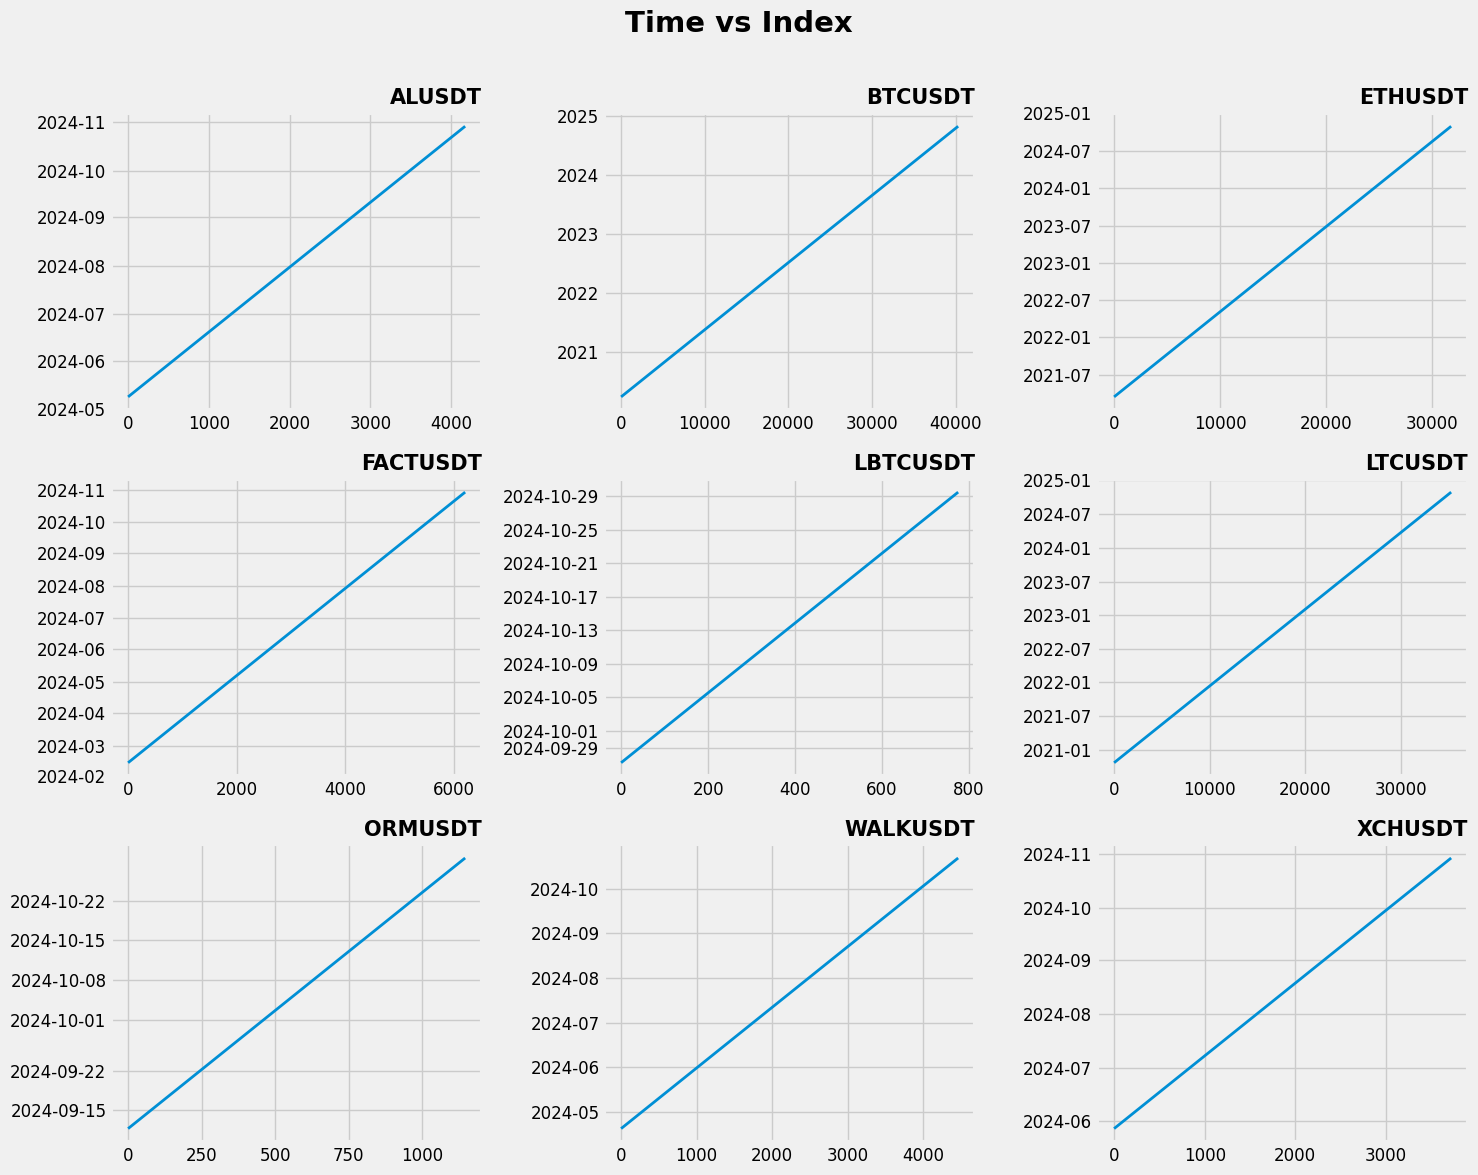

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob.glob("../optimizer/ticker_dataframes/*_1h.pkl")
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if "/BTCUSDT_1h" in t or "/ETHUSDT_1h" in t or "/LTCUSDT_1h" in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df["time"])

        ax.set_ylabel("")
        plt.yticks(fontsize=12) 
        ax.set_xlabel("")
        plt.xticks(fontsize=12)
        # ax.spines["right"].set_visible(False)
        ax.set_title(f"{random_tickers[idx].split('/')[-1][:-7]}", loc="right", weight="bold", fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f"Time vs Index\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob("../optimizer/ticker_dataframes/*.pkl")
y = {i[31:].split("USDT")[0] + "USDT" for i in x}
z = ("").join(x)

for i in y:
    if f"{i}_1h" not in z:
        print(i, "1h")
    if f"{i}_4h" not in z:
        print(i, "4h")

XWGUSDC_1h.pklUSDT 1h
XWGUSDC_1h.pklUSDT 4h
XWGUSDC_4h.pklUSDT 1h
XWGUSDC_4h.pklUSDT 4h
EURCUSDC_1h.pklUSDT 1h
EURCUSDC_1h.pklUSDT 4h
EURCUSDC_4h.pklUSDT 1h
EURCUSDC_4h.pklUSDT 4h


# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ["time", "linear_reg", "linear_reg_angle", "macd", "macdhist", "macdsignal"]
price_cols = ["open","high", "low", "close"]
real_price_cols = ["real_high", "real_low", "real_close"]
funding_cols = ["funding_rate"]
rsi_stoch_cols = ["rsi", "stoch_diff", "stoch_slowd", "stoch_slowk"]
btcd_cols = ["time", "btcd_open", "btcd_high", "btcd_low", "btcd_close", "btcd_volume"]
btcdom_cols = ["time", "btcdom_open", "btcdom_high", "btcdom_low", "btcdom_close", "btcdom_volume"]

def get_file(ticker):
    """ Find files buy ticker names """
    try:
        tmp_df_1h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
        tmp_df_4h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h


def add_indicators(df: pd.DataFrame, df_higher: pd.DataFrame, ttype: str, configs: dict) -> pd.DataFrame:
    """Create indicators and add them to the dataset"""
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, "", "", 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, "", "", 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, "", "", 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, "", "", 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, "", "", 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, "", "", 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, "", "", 0)
    # merge higher timeframe indicators with working timeframe
    df_higher["time"] = df_higher["time"] + pd.to_timedelta(3, unit="h")
    df[higher_features] = pd.merge(df[["time"]], df_higher[higher_features], how="left", on="time")
    df = df.drop(columns=["close_smooth"])
    df = df.drop(columns=[c for c in df.columns if c.endswith("_dir")])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[["time"]], btcd[btcd_cols], how="left", on="time")
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[["time"]], btcdom[btcdom_cols], how="left", on="time")
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[["high", "low", "close"]]
    cols_to_scale = ["open", "high", "low", "close", "macd", "macdhist", "macdsignal", "atr"]
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ["close", "btcd_close", "btcdom_close"]:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f"{col}_{agg_func.__name__}_{period}"] = df[col].rolling(period, min_periods=1).agg({"func": agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    """ Create train dataset from signal statistics and ticker candle data"""
    train_df = list()
    tickers = df["ticker"].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df["ticker"] == ticker]
        times = signal_df["time"]
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev["ticker"] == ticker, "time"].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f"TypeError, ticker - {ticker}")
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc("pattern")]
            row = tmp_df_1h.loc[tmp_df_1h["time"] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h["time"] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f"_prev_{i}" for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row["ticker"] = ticker
                row["pattern"] = pattern
                
            if pass_cycle:
                continue

            row["target"] = 0
            row["max_price_deviation"] = 0
            row["min_price_deviation"] = 0
            row["first_price"] = 0
            row["last_price"] = 0
            row["ttype"] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith("MACD"):
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t + timedelta(hours=3), "real_close"]
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t, "real_close"]
            

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue

            row["first_price"] = close_price.values[0]
            row["close_time"] = row["time"].values[0] + pd.to_timedelta(target_offset, unit="h")
            
            close_price = close_price.values[0]
            if ttype == "buy":
                higher_price = close_price * CFG.cls_target_ratio_sl
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
            else:
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_sl)
            
            target_buys, target_sells = [], []
            for i in range(1, target_offset + 1):
                
                if pattern.startswith("MACD"):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_high"]
                target_sell = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_low"]
                
                target_buys.append(target_buy)
                target_sells.append(target_sell)
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set TPs and SLs
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row["pattern"].values[0]
                ttype = row["ttype"].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith("STOCH") and ttype == "buy" and target_buy_sl == 1
                sl2 = pattern.startswith("STOCH") and ttype == "sell" and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith("STOCH") and ttype == "buy" and target_sell_tp == 1
                tp2 = pattern.startswith("STOCH") and ttype == "sell" and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                elif sl1 or sl2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    break
                elif tp1 or tp2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    if row["close_time"].values[0] == row["time"].values[0] + pd.to_timedelta(target_offset, unit="h"):
                        row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    row["target"] = 1
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_close"].values[0]
                    l1 = pattern.startswith("STOCH") and ttype == "buy" and last_price < close_price
                    l2 = pattern.startswith("STOCH") and ttype == "sell" and last_price > close_price
                    # if price doesn't reach both TP and SL - write its last price
                    if row["target"].values[0] == 0:
                        row["last_price"] = last_price

                    if l1 or l2:
                        row["target"] = 1

                # set the maximum price deviation to the correct side for the current trade period 
                if ttype == "sell":
                    curr_price_pos = (target_buy - close_price) / close_price
                    curr_price_neg = (close_price - target_sell) / close_price
                else:
                    curr_price_pos = (close_price - target_sell) / close_price
                    curr_price_neg = (target_buy - close_price) / close_price
                
                row["max_price_deviation"] = max(row["max_price_deviation"].values[0], curr_price_pos) 
                row["min_price_deviation"] = max(row["min_price_deviation"].values[0], curr_price_neg) 
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            train_df.append(row)
    
    train_df = pd.concat(train_df).reset_index(drop=True)
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist("BTC.D","CRYPTOCAP", interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns="symbol")
    btcd.columns = btcd_cols
    btcd["time"] = btcd["time"] + pd.to_timedelta(23, unit="h")

    btcdom = tv.get_hist("BTCDOMUSDT.P","BINANCE", interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns="symbol")
    btcdom.columns = btcdom_cols
    btcdom["time"] = btcdom["time"] + pd.to_timedelta(3, unit="h")
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 3, 15, 16, 17, 18, 19, 21, 22, 23]
    df = df[df["time"].dt.hour.isin(buy_hours_to_save)] 
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, "buy", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [2, 5, 8, 9, 11, 14, 17]
    df = df[df["time"].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, "sell", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, "buy", configs, CFG.target_offset, first, CFG.last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values("time").reset_index(drop=True)

    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, "sell", configs, CFG.target_offset, first, CFG.last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values("time").reset_index(drop=True)

    del df

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
train_sell = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values("time")

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df["time"] < train_df["time"].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if "prev" not in c and "sar" in c]

# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r"_prev_\d+", "", c) for c in train_buy.columns)

    agg_funcs = ["amin", "amax", "mean", "median", "std"]
    agg_cols = [c for c in cols if len(c.split("_")) > 2 and c.split("_")[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ["atr", "cci", "sar", "volume", "pattern", "target", "max_price_deviation",
                                                              "min_price_deviation", "ticker", "ttype", "close_time", "first_price", "last_price"])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ("rsi" in c or "stoch" in c) and "diff" not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if "volume" in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith("funding")]
    for f_c in funding_cols_:
        num = "".join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith("btcd_") and "volume" not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = "".join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = "".join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # check if columns that were added for backtest and statistics are correct
    for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
        if row["last_price"] > 0:
            assert row["close_time"] - row["time"] == pd.to_timedelta(CFG.target_offset, unit="h")
            assert round(row["max_price_deviation"], 8) <= CFG.cls_target_ratio_tp - 1
        else:
            assert row["close_time"] - row["time"] <= pd.to_timedelta(CFG.target_offset, unit="h")
            if row["target"] == 1:
                assert round(row["max_price_deviation"], 8) >= CFG.cls_target_ratio_tp - 1
            else:
                assert round(row["max_price_deviation"], 8) < CFG.cls_target_ratio_tp - 1

    # plot time values 
    train_df["time"].plot(title="Signal Time distribution")


### Test buy target corectness

In [11]:
prev_ticker = None

train_buy_ = train_buy[train_buy["ticker"] == "MILOUSDT"]

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]
        if ticker != "MILOUSDT":
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_sl
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        
        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        high_price = close_price * CFG.cls_target_ratio_tp
        low_price = close_price * (2 - CFG.cls_target_ratio_sl)
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]

        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Find minimum acceptable class 1 / class 0 ratio considering singal statistics and our TP / SL ratio

In [13]:
# if target = 1 but price didn't reach TP - what is percent of cases when it happenes and what is average positive price movement
low_price_dev_num_1 = train_buy.query("target == 1 & max_price_deviation < @CFG.cls_target_ratio_tp - 1").shape[0]
normal_price_dev_num_1 = train_buy.query("target == 1").shape[0]
avg_low_price_dev_1 = train_buy.query("target == 1 & max_price_deviation < @CFG.cls_target_ratio_tp - 1")["max_price_deviation"].mean()
low_2_norm_ratio_1 = low_price_dev_num_1/normal_price_dev_num_1

# if target = 0 but price didn't reach SL - what is percent of cases when it happenes and what is average negative price movement
low_price_dev_num_0 = train_buy.query("target == 0 & min_price_deviation < @CFG.cls_target_ratio_sl - 1").shape[0]
normal_price_dev_num_0 = train_buy.query("target == 0").shape[0]
avg_low_price_dev_0 = train_buy.query("target == 0 & min_price_deviation < @CFG.cls_target_ratio_sl - 1")["min_price_deviation"].mean()
low_2_norm_ratio_0 = low_price_dev_num_1/normal_price_dev_num_0

for class_1_ratio in np.arange(0.51, 0, -0.001):
    expectation = ((CFG.cls_target_ratio_tp - 1) * (1 - low_2_norm_ratio_1) + avg_low_price_dev_1 * low_2_norm_ratio_1) * class_1_ratio -\
           ((CFG.cls_target_ratio_sl - 1) * (1 - low_2_norm_ratio_0) + avg_low_price_dev_0 * low_2_norm_ratio_0) * (1 - class_1_ratio)
    if expectation < 0:
        print(round(class_1_ratio + 0.001, 4))
        break

0.5


### Test pattern / target distribution

In [14]:
def q10(x):
    return x.quantile(0.1)

def q20(x):
    return x.quantile(0.2)

def q30(x):
    return x.quantile(0.3)

def q90(x):
    return x.quantile(0.9)

def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row["total"], row["count"]
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy[(train_buy["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Buy")
display(pvt)
display(train_buy["ttype"].value_counts())
display(train_buy[["target", "pattern"]].value_counts())
display(train_buy[["target", "pattern"]].value_counts(normalize=True))
# find hours where lower trust interval of class 1 / class 0 ratio 
# is bigger than minimum acceptable class 1 / class 0 ratio
mask = pvt["trust_interval"].apply(lambda x: x[0]) > class_1_ratio
display(pvt.loc[mask, "hour"].tolist())

pvt = train_sell[(train_sell["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Sell")
display(pvt)
display(train_sell["ttype"].value_counts())
display(train_sell[["target", "pattern"]].value_counts())
display(train_sell[["target", "pattern"]].value_counts(normalize=True))
# find hours where lower trust interval of class 1 / class 0 ratio 
# is bigger than minimum acceptable class 1 / class 0 ratio
mask = pvt["trust_interval"].apply(lambda x: x[0]) > class_1_ratio
display(pvt.loc[mask, "hour"].tolist())

Buy


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.126071,0.055340,0.065159,0.079461,0.301322,912,1585,0.575394,"(0.5512, 0.5996)"
3,1,1,0.128085,0.056505,0.069703,0.085310,0.330993,994,1800,0.552222,"(0.5294, 0.5751)"
5,3,1,0.124118,0.057483,0.069628,0.084429,0.282929,1210,2168,0.558118,"(0.5373, 0.5789)"
7,15,1,0.134867,0.058498,0.074144,0.092150,0.289541,856,1523,0.562049,"(0.5373, 0.5868)"
9,16,1,0.117656,0.056954,0.071188,0.085502,0.269007,748,1405,0.532384,"(0.5064, 0.5583)"
11,17,1,0.111708,0.056942,0.066383,0.079779,0.269866,814,1440,0.565278,"(0.5398, 0.5908)"
13,18,1,0.123602,0.056306,0.068730,0.085031,0.271624,755,1421,0.531316,"(0.5055, 0.5571)"
15,19,1,0.124262,0.055361,0.066051,0.082009,0.262075,727,1355,0.536531,"(0.5101, 0.5629)"
17,21,1,0.118886,0.055104,0.064492,0.079401,0.285398,827,1514,0.546235,"(0.5213, 0.5712)"
19,22,1,0.122435,0.056637,0.070798,0.084848,0.294331,880,1530,0.575163,"(0.5505, 0.5998)"


buy    17988
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    10001
0       STOCH_RSI_Volume24     7987
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.555982
0       STOCH_RSI_Volume24    0.444018
dtype: float64

[0, 1, 3, 15, 16, 17, 18, 19, 21, 22, 23]

Sell


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,2,1,0.104834,0.054238,0.064280,0.074745,0.296245,792,1507,0.525547,"(0.5005, 0.5506)"
3,5,1,0.117836,0.058485,0.068197,0.081865,0.372126,981,1881,0.521531,"(0.4991, 0.544)"
5,8,1,0.114004,0.056607,0.067004,0.080402,0.325029,868,1617,0.536797,"(0.5126, 0.561)"
7,9,1,0.124614,0.060417,0.071634,0.085488,0.317371,819,1487,0.550773,"(0.5256, 0.5759)"
9,11,1,0.122756,0.059499,0.069257,0.083780,0.379406,690,1285,0.536965,"(0.5098, 0.5641)"
11,14,1,0.119487,0.057625,0.067031,0.080408,0.332991,781,1483,0.526635,"(0.5014, 0.5519)"
13,17,1,0.116254,0.055214,0.065589,0.077362,0.363041,542,1020,0.531373,"(0.5009, 0.5618)"


sell    10755
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5713
0       STOCH_RSI_Volume24    5042
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.531195
0       STOCH_RSI_Volume24    0.468805
dtype: float64

[2, 5, 8, 9, 11, 14, 17]

# Data visualization

### Plot ratio of class 1 for every week day

Monday = 0, Sunday = 6

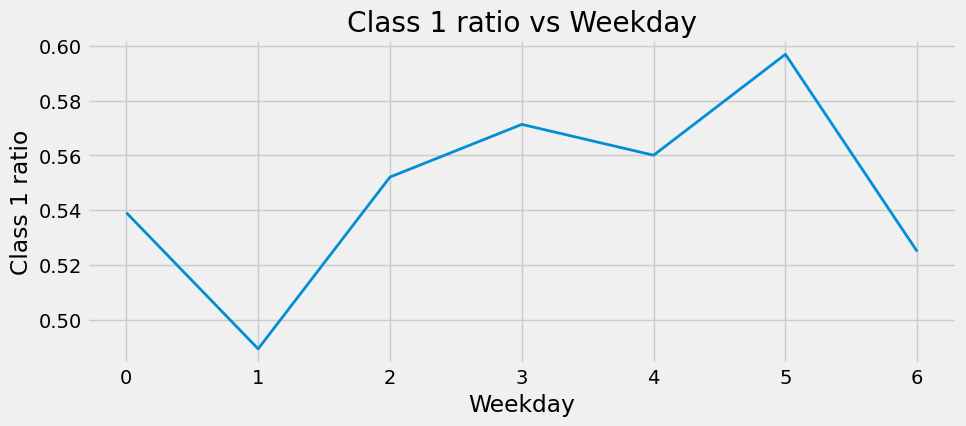

In [15]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["weekday"] = group_df["time"].dt.weekday
ax = group_df.groupby("weekday")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Weekday")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Weekday");

### Plot ratio of class 1 for every month

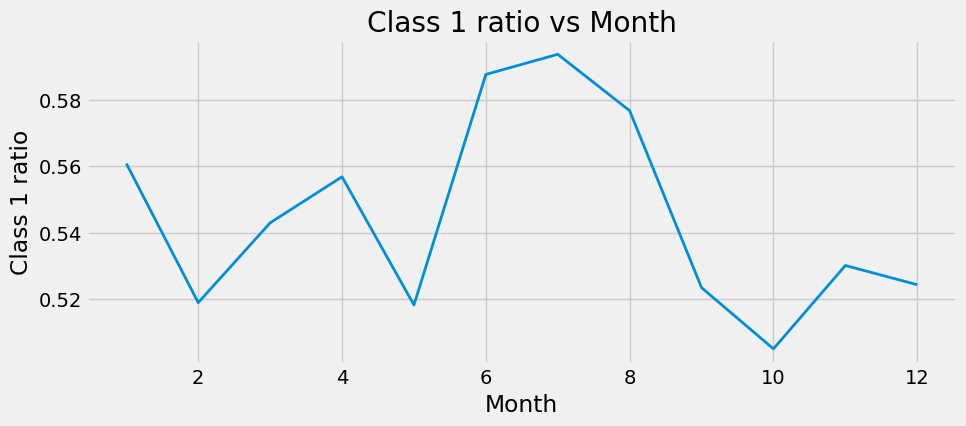

In [16]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["month"] = group_df["time"].dt.month
ax = group_df.groupby("month")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Month")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Month");

### Plot ratio of class 1 for every day of last months

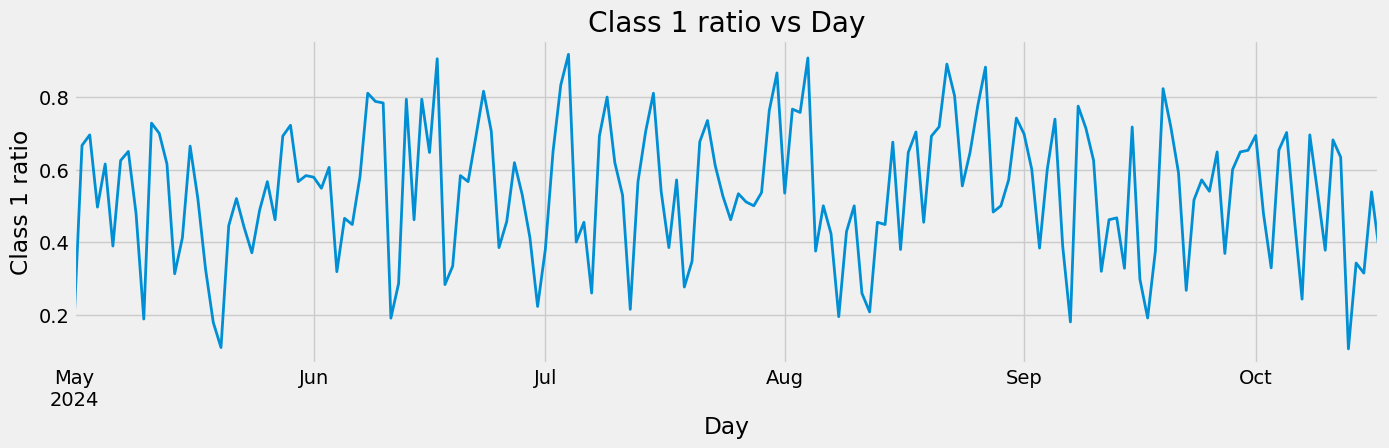

In [17]:
plt.figure(figsize=(15, 4))

group_df = train_df[(train_df["time"].dt.year >= 2024) & (train_df["time"].dt.month >= 5)]
group_df["day"] = group_df["time"].dt.to_period("D")
ax = group_df.groupby("day")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Day")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Day");

### Visualize buy trades

In [18]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]

        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_sl
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [19]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]
        
        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_sl)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

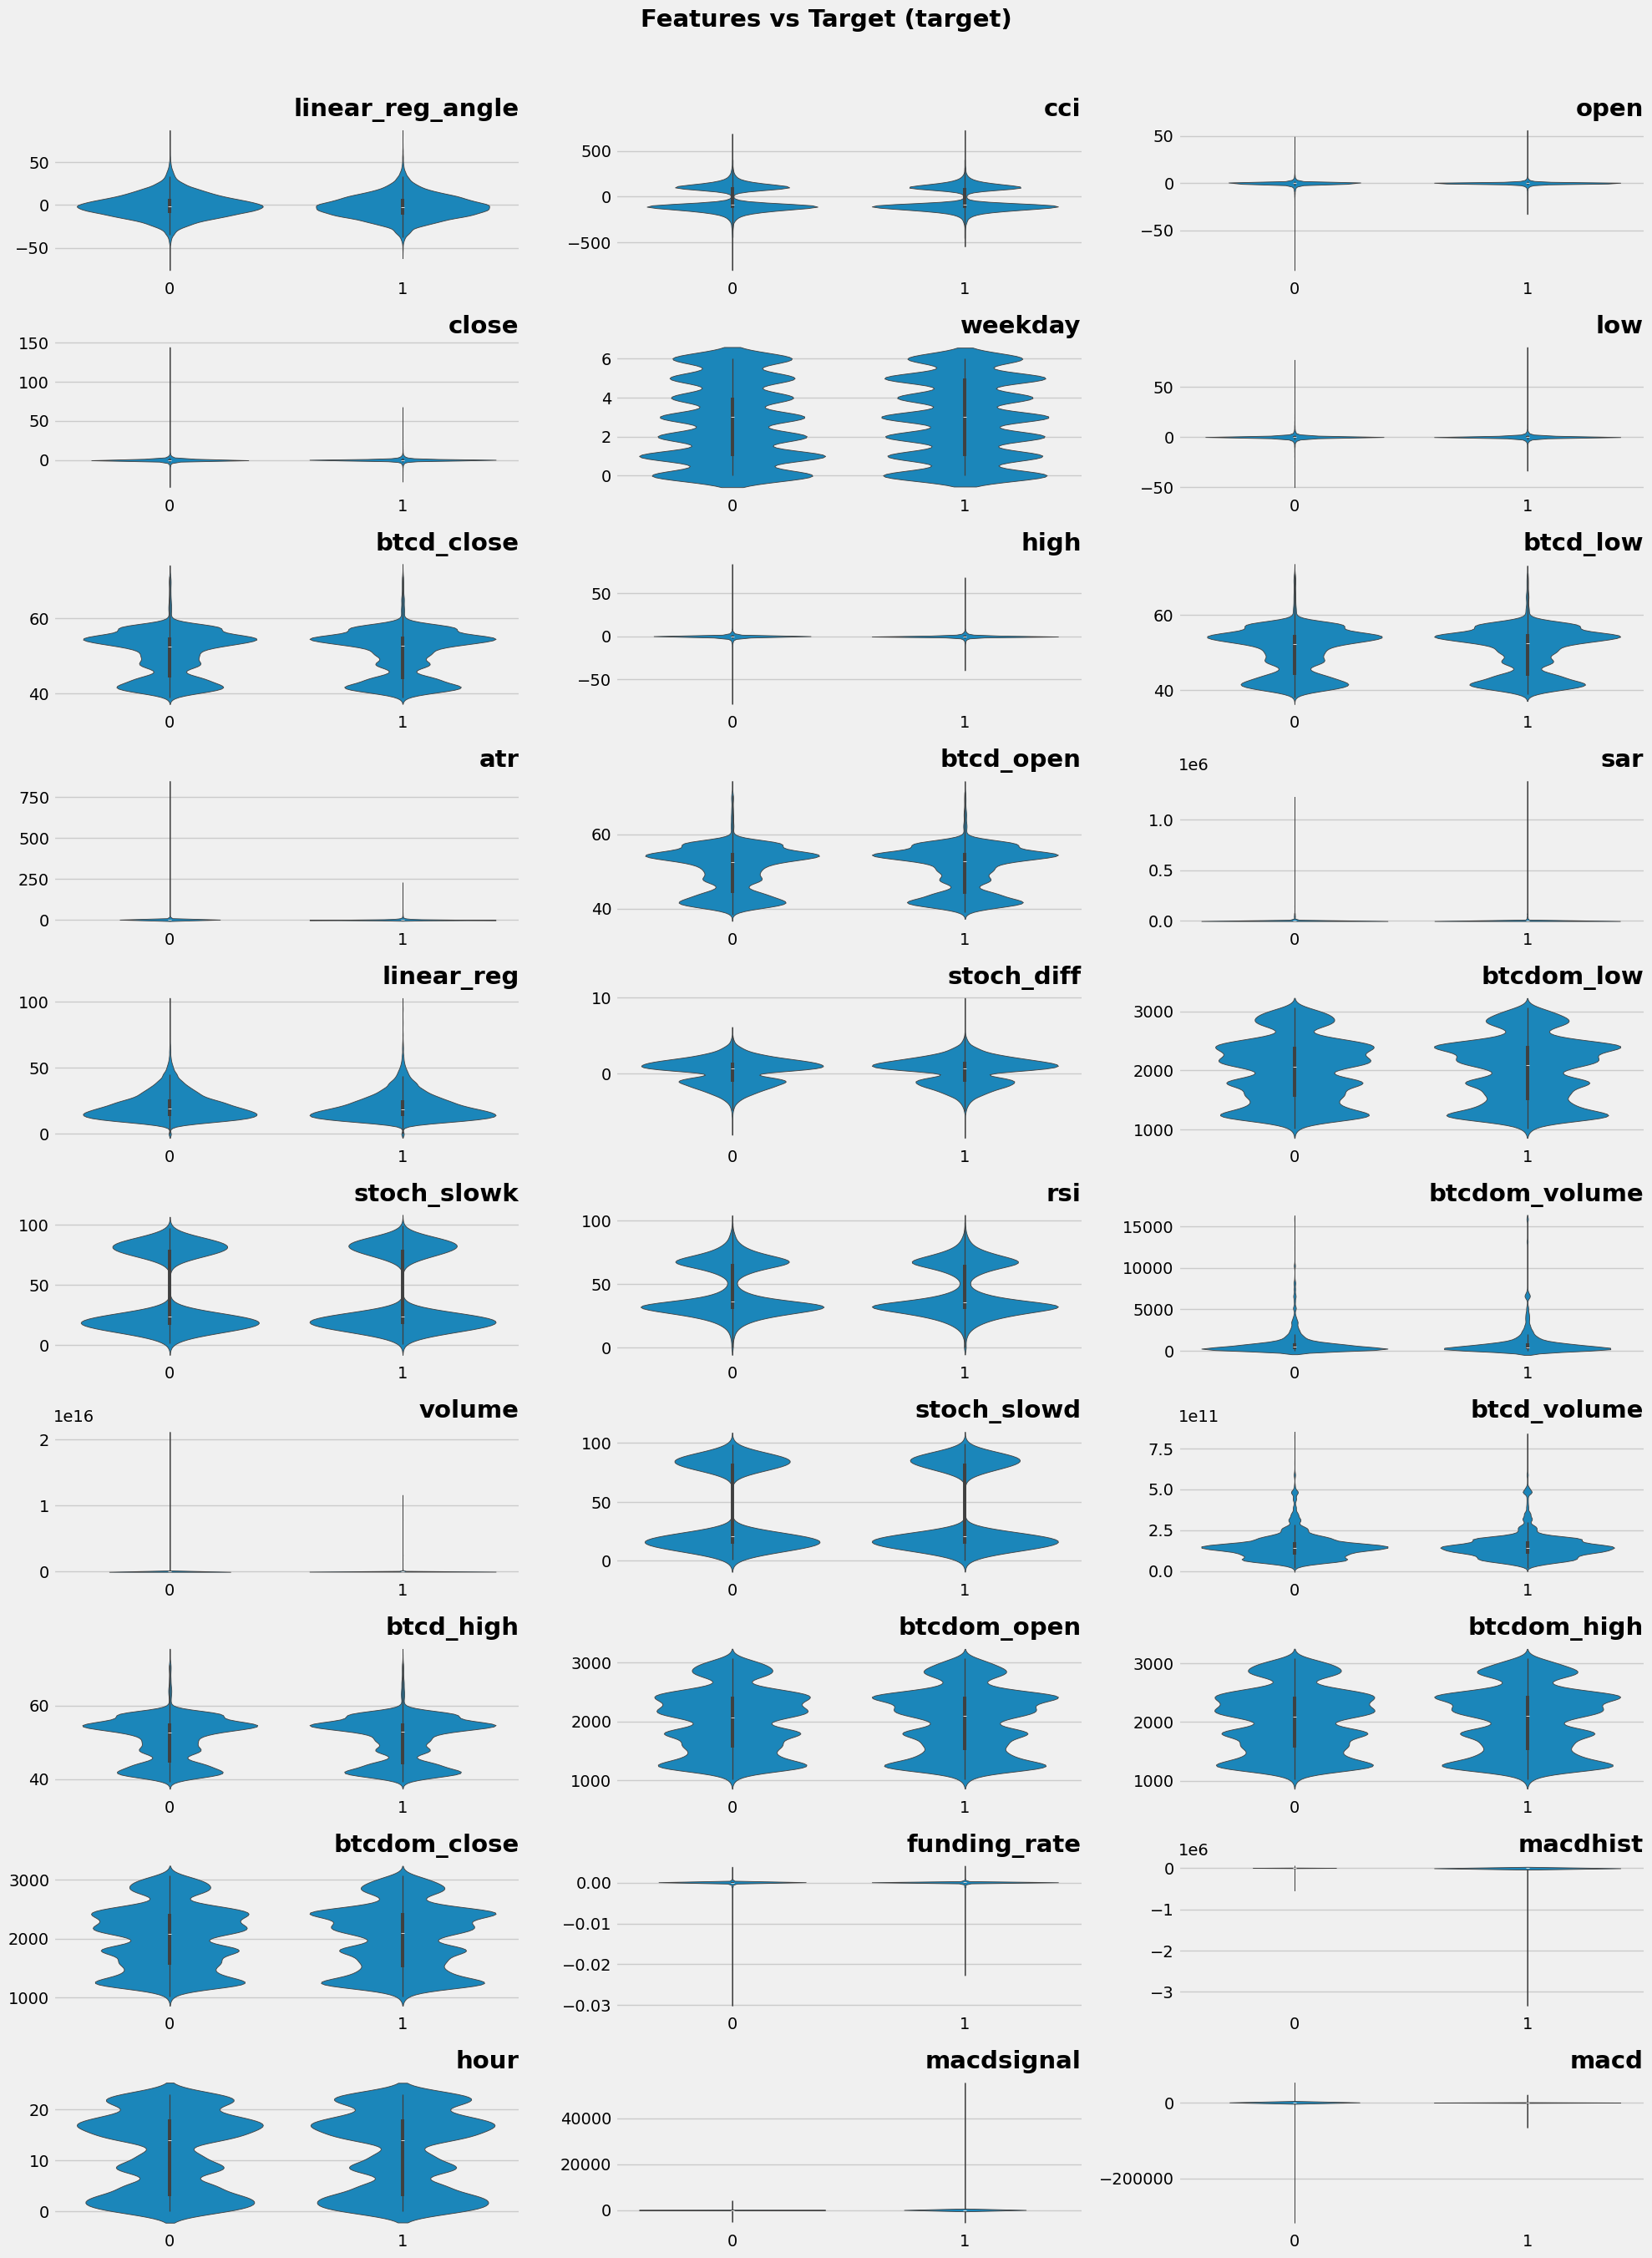

In [20]:
train_df["hour"] = train_df["time"].dt.hour
train_df["weekday"] = train_df["time"].dt.weekday

fi = pd.read_csv(f"model/feature_importance.csv")["Feature"].to_list()
cols = [c for c in fi if "prev" not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(""); ax.spines["top"].set_visible(False), 
        ax.set_xlabel(""); ax.spines["right"].set_visible(False)
        ax.set_title(f"{col}", loc="right", weight="bold", fontsize=21)

    
    fig.suptitle(f"Features vs Target ({target})\n\n\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target="target")

### Show the last signals

In [21]:
x = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
x["ttype"] = "buy"
y = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
y["ttype"] = "sell"
x = pd.concat([x, y]).sort_values("time").reset_index(drop=True)
x.loc[x["pattern"] == "STOCH_RSI_Volume24", ["time", "ticker", "ttype", "pattern"]].tail(50)

,time,ticker,ttype,pattern
92840,2024-10-29 10:00:00,APFCUSDT,sell,STOCH_RSI_Volume24
92841,2024-10-29 10:00:00,IOTXUSDT,sell,STOCH_RSI_Volume24
92842,2024-10-29 10:00:00,IOTAUSDT,sell,STOCH_RSI_Volume24
92843,2024-10-29 10:00:00,RENUSDT,sell,STOCH_RSI_Volume24
92844,2024-10-29 10:00:00,HOTUSDT,sell,STOCH_RSI_Volume24
92845,2024-10-29 10:00:00,BNTUSDT,sell,STOCH_RSI_Volume24
92846,2024-10-29 10:00:00,INJUSDT,sell,STOCH_RSI_Volume24
92847,2024-10-29 10:00:00,STXUSDT,sell,STOCH_RSI_Volume24
92848,2024-10-29 10:00:00,ICXUSDT,sell,STOCH_RSI_Volume24
92849,2024-10-29 10:00:00,BATUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [22]:
from shaphypetune import BoostBoruta
  
params = {
          "boosting_type": "gbdt",
          "n_estimators": 1000,
          "learning_rate": 0.02,
          "max_depth": 10,
          "subsample" : 0.7,
          "colsample_bytree": 0.7,
          "num_leaves": 24,
          "verbosity": -1,
          "importance_type": "gain",
          "max_bin": 255,
          "reg_alpha": 1e-6,
          "reg_lambda": 1e-7,
          "objective": "binary",
          "metric": "auc",
          "verbose": -1
        }
features = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "weight",
                                                     "max_price_deviation", "min_price_deviation", "close_time", "first_price", "last_price"]]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return "ppv_npv_acc", ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = "logloss"

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f"Fold: {fold}")
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type="shap_importances", train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric="logloss", 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({"importance": model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values("importance")
    boruta_df_ = boruta_df_.reset_index().rename({"index": "Feature"}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [23]:
palette = ["#302c36", "#037d97", "#E4591E", "#C09741",
           "#EC5B6D", "#90A6B1", "#6ca957", "#D8E3E2"]

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# load the list of Bybit tickers
with open(f"model/bybit_tickers.json", "r") as f:
    bybit_tickers = json.load(f)

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]
    
    for fold in range(CFG.n_repeats):
        print(f"Repeat {blu}#{fold+1}")

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric="logloss", 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f"Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}")

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=["Value","Feature"])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_["Value"] += f_i["Value"]
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({"importance": perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f"{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}")
    print(f"{'*' * 50}\n")
    
    if permut:
        perm_df_ = perm_df_.sort_values("importance", ascending=False)
        perm_df_ = perm_df_.reset_index().rename({"index": "Feature"}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values("Value", ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          "penalty": "l2",
          "max_iter": 10000,
          "C": 1
        }

    scaler = StandardScaler()
    X, y = df[features], df["target"]
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({"importance": selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({"index": "Feature"}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [25]:
if CFG.select_features:
    boruta_df_["rank"] = boruta_df_["importance"].rank()
    perm_df_["rank"] = perm_df_["importance"].rank(ascending=False)
    rfe_df_["rank"] = rfe_df_["importance"]
    feature_importances_["rank"] = feature_importances_["Value"].rank(ascending=False)

    fi = pd.concat([perm_df_[["Feature","rank"]], feature_importances_[["Feature","rank"]], rfe_df_[["Feature","rank"]],
                    boruta_df_[["Feature","rank"]]])
    fi = fi.groupby("Feature")["rank"].sum().sort_values().reset_index()
    fi.to_csv(f"model/feature_importance.csv", index=False)
else:
    fi = pd.read_csv(f"model/feature_importance.csv")

# Train

### Load best parameters from Optuna dataframe

In [26]:
def load_params_from_optuna(row_num=0) -> dict:
    try:
        optuna_df = pd.read_csv("optuna/optuna_lgbm.csv")
    except FileNotFoundError:
        return {}
    columns = [c for c in optuna_df.columns if c.startswith("params_")]
    row = optuna_df[columns].iloc[row_num]
    params = {key[7:]: value for key, value in row.to_dict().items()}
    if params["sample_weight"] != params["sample_weight"]:
        params["sample_weight"]  = None
    if params["is_unbalance"] is True:
        if "class_weight" not in params or params["class_weight"] != params["class_weight"]:
            params["class_weight"] = None
        else:
            params["class_weight"] = "balanced"
    return params

params = load_params_from_optuna(row_num=0)
params

{'boosting_type': 'goss',
 'colsample_bytree': 0.512017204593037,
 'corr_thresh': 0.6320245085169811,
 'feature_num': 40,
 'high_bound': 0.4633629735750778,
 'is_unbalance': True,
 'learning_rate': 0.0147859156512604,
 'low_bound': 0.0111000093087904,
 'max_bin': 190,
 'max_depth': 4,
 'max_train_size': 0.5776052433624246,
 'n_estimators': 2324,
 'num_leaves': 4,
 'reg_alpha': 3.0125481840800675e-08,
 'reg_lambda': 0.000617123193957,
 'sample_weight': None,
 'subsample': nan,
 'class_weight': None}

### Load selected features

In [27]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations["level_0"] != correlations["level_1"]] 
    correlations.columns = ["feature_1", "feature_2", "corr"]

    correlations = pd.merge(left=correlations, right=fi, how="left", left_on="feature_1", right_on="Feature")
    correlations = correlations.drop(columns="Feature")
    correlations = correlations.sort_values(["corr", "rank"], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations["corr"] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row["feature_1"]
        feature_2 = row["feature_2"]

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    """ Get features, sort them by their time appearance and return for using in train and inference"""
    # exclude some features 
    fi = fi["Feature"]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == "volume_24":
            feature_dict[0].append(f)
            continue
        period = f.split("_")
        if period[-1].isdigit() and period[-2] == "prev":
            feature_dict[int(period[-1])].append("_".join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f"_prev_{item[0]}" for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    
    # remove highly correlated features from the feature dict
    feature_dict["features"] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f"{f}_prev_{item[0]}"
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

if "feature_num" in params:
    feature_num = params["feature_num"]
    corr_thresh = params["corr_thresh"]

    del params["feature_num"]
    del params["corr_thresh"]

# feature_num = 58
# corr_thresh = 0.5324216723399987
fi = pd.read_csv("model/feature_importance.csv")
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['linear_reg_angle',
 'cci',
 'btcdom_volume_prev_12',
 'btcdom_volume_prev_24',
 'cci_prev_28',
 'close_prev_56',
 'btcd_volume_prev_72',
 'btcdom_volume_prev_84',
 'close_prev_88',
 'rsi_prev_92',
 'close_prev_92',
 'btcdom_volume_prev_112',
 'btcd_volume_prev_120',
 'btcdom_volume_prev_128',
 'btcdom_volume_prev_172',
 'btcdom_volume_prev_188',
 'btcd_volume_prev_192',
 'high_prev_196',
 'btcdom_volume_prev_204',
 'atr_prev_212',
 'btcdom_volume_prev_220',
 'btcdom_volume_prev_228',
 'btcdom_volume_prev_240',
 'atr_prev_240',
 'btcdom_volume_prev_256',
 'close_prev_268',
 'close_prev_272']

27

### Functions for train

In [28]:
from __future__ import annotations
from scipy.stats import ttest_rel


def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, sample_weight: Union[list, None],
                n_folds: int, low_bound: float, high_bound: float, train_test: str, 
                max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == "fold")
        - list of profitable objects by folds (if train_test == "fold")
    """
    X, time = df[features], df["time"]
    y = df["target"]
    val_idxs = []
    conf_scores =[]
    conf_object_nums = []
    max_train_size = int(len(df) * max_train_size)
    
    if train_test == "fold":
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f"Fold #{fold + 1}")
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], "time"])
                display(df.loc[val_idx[-1], "time"])

                plt.plot(train_df.index[fit_idx], [fold + 1] * len(fit_idx), label=f'Train {fold + 1}', color='blue')
                plt.plot(train_df.index[val_idx], [fold + 1] * len(val_idx), label=f'Test {fold + 1}', color='red')
                
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            if sample_weight is not None:
                sample_weight = df.loc[fit_idx, "weight"]
            else:
                sample_weight = None
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, sample_weight=sample_weight, 
                          eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric="logloss", callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:, 1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f"Logloss: {val_score}, Confident objects score: {conf_score}\n"
                      f"Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n"
                      f"Number of profitable objects: {round((2 * conf_score - 1) * conf_obj_num)}")
        
        if verbose:
            plt.ylim(0.5, n_folds + 0.5)
            plt.xlabel('Index')
            plt.ylabel('Fold')
            plt.title('Train/Test Distribution for Time-Series Split')
            plt.legend(['Train', 'Test'], loc='lower right')
            plt.show()
        
        return model_lgb, conf_scores, conf_object_nums, oof, val_idxs
    elif train_test == "inference":
        print("Train on the latest data")
        X, y = df.iloc[-max_train_size:][features], df.iloc[-max_train_size:]["target"]
        if sample_weight is not None:
                sample_weight = df.iloc[-max_train_size:]["weight"]
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, sample_weight=sample_weight, eval_set=[(X, y)], 
                      eval_metric="logloss", callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Functions for backtest

In [29]:
TP = 0.08 # real take profit that we set in our trade
SL = 0.05
risk = 0.0026 # what part of deposit we use in one trade
leverage = 4
price_change = SL * leverage
min_free_balance = 0.2

open_comission = 0.00036 # Bybit comission for trade opening
close_comission = 0.001 # Bybit comission for trade closing

# consider trade slippage, let it be ~ 0.2%
slippage = 0.002
TP -= slippage
SL += slippage

def calculate_profit(target, quantity, first_price, last_price):
    """Calculate profit change according to trade success and comissions"""
    if target == 1:
        if last_price > 0: 
            # if price doesn't reach TP or SL - calculate profit
            # from price of entering and exiting of trade
            trade_profit = quantity * (1 + (last_price - first_price) / first_price * leverage)
        else:
            # TP reached
            trade_profit = quantity * (1 + TP * leverage)
    else:
        # SL reached
        trade_profit = quantity * (1 - SL * leverage)
        
    # subtract Bybit close comission 
    trade_profit *=  (1 - close_comission)
    # subtract possible slippage

    profit = trade_profit - quantity
    return profit, trade_profit


def cap_max_num_simult_trades(df, max_num_simult_trades):
    """ Cap the maximum number of simulatenously opened trades """
    df["row_number"] = df.sort_values("pred", ascending=False).groupby("time")["target"].cumcount() + 1
    df = df[df["row_number"] <= max_num_simult_trades]
    return df


def backtest(df: pd.DataFrame, oof: pd.Series, val_idxs: pd.Series, high_bound: float, 
             show_progress: bool = False, max_num_simult_trades: int = 0) -> float:
    # 
    """Function for model backtest"""
    # select only trades in which model is confident
    backtest_df = df.loc[val_idxs, ["target", "max_price_deviation", "time", "close_time", "first_price", "last_price"]]
    backtest_df["pred"] = oof
    backtest_df = backtest_df[backtest_df["pred"] >= high_bound]
    if max_num_simult_trades > 0:
        backtest_df = cap_max_num_simult_trades(backtest_df, max_num_simult_trades)
    backtest_df = backtest_df.reset_index(drop=True)
    backtest_df["balance"] = 1
    backtest_df["free_balance"] = 1
    backtest_df["profit"] = 0
    backtest_df["trade_profit"] = 0
    backtest_df["quantity"] = 0
    backtest_df["profit_count"] = 0

    # set for tracking of not closed trades
    not_closed_trade_idxs = set()
    
    if show_progress:
        generator = tqdm(backtest_df.iterrows(), total=len(backtest_df))
    else:
        generator = backtest_df.iterrows()

    # move through the dataset row-by-row
    for i, row in generator:
        j = i - 1
        # take balance from previous signal 
        # or if signal is first - set balance to 1
        if j >= 0:
            balance = backtest_df.loc[j, "balance"]
            free_balance = backtest_df.loc[j, "free_balance"]
        else:
            balance = free_balance = 1
        
        signal_time = row["time"]
        target = row["target"]
        first_price = row["first_price"]
        last_price = row["last_price"]
        
        closed_trade_idxs = []
        
        # update balance with previous signals info
        for j in not_closed_trade_idxs:
            prev_signal_close_time = backtest_df.loc[j, "close_time"]
            # if previous signal was closed - add its profit to the current balance 
            if signal_time >= prev_signal_close_time:
                free_balance += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "trade_profit"] += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "profit_count"] += 1
                closed_trade_idxs.append(j)

        # remove closed trades from set of not closed trades
        for j in closed_trade_idxs:
            not_closed_trade_idxs.remove(j)

        # perform trading operation only if have enough of free balance
        if free_balance >= min_free_balance * balance:
            # calculate quantity to use in trade
            quantity = free_balance * risk / price_change
            # subtact quantity + open comission from balance
            balance -= quantity * open_comission
            free_balance -= (quantity * (1 + open_comission))
            # get profit from the current trade
            profit, trade_profit = calculate_profit(target, quantity, first_price, last_price)
        else:
            profit, trade_profit = 0, 0

        # write balance and profit to the dataset
        backtest_df.loc[i, "quantity"] = quantity
        backtest_df.loc[i, "balance"] = balance + profit
        backtest_df.loc[i, "free_balance"] = free_balance
        backtest_df.loc[i, "profit"] = profit
        backtest_df.loc[i, "trade_profit"] = trade_profit

        not_closed_trade_idxs.add(i)

    if len(backtest_df) > 0:
        result = round(backtest_df['balance'].iloc[-1] * 100, 2) - 100
    else:
        result = 0
    return result, backtest_df

### Functions for optimization

In [30]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     "device": "gpu",
#                     "gpu_platform_id": 0,
#                     "gpu_device_id": 0,
        "objective": "binary",
        "metric": "average_precison",
        "boosting_type": trial.suggest_categorical("boosting_type", ["dart", "goss", "gbdt"]), 
        # Hyperparamters (in order of importance decreasing)
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),  # max number of trees in model
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 3e-1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        "max_depth": trial.suggest_int("max_depth", 4, 10), # tree max depth 
         # decrease to deal with overfit
        "num_leaves": trial.suggest_int("num_leaves", 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        "max_bin": trial.suggest_int("max_bin", 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        "subsample_freq": 1, # Perform bagging at every k iteration, alias: bagging_freq

        # "subsample_for_bin": 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # "cat_smooth": trial.suggest_float("cat_smooth", 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),                                            
        "verbose": -1,
        "importance_type": "gain",
        "high_bound": trial.suggest_float("high_bound", 0.3, 0.65),
        "low_bound": trial.suggest_float("low_bound", 0.0, 0.1),
        "feature_num": trial.suggest_int("feature_num", 30, 600),
        "corr_thresh": trial.suggest_float("corr_thresh", 0.5, 0.99),
        "max_train_size": trial.suggest_float("max_train_size", 0.5, 1),
        "sample_weight": trial.suggest_categorical("sample_weight", [None, "cos", "linear"])
    }
    
    if params["boosting_type"] != "goss":
        params["subsample"] = trial.suggest_float("subsample", 0.3, 0.9)

    if params["is_unbalance"] == "True":
        params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None]), 
    else:
        params["class_weight"] = None

    high_bound = params["high_bound"]
    del params["high_bound"]

    low_bound = params["low_bound"]
    del params["low_bound"]

    corr_thresh = params["corr_thresh"]
    del params["corr_thresh"]

    # set max train size for TSS fold
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

    # add object weights
    sample_weight = params["sample_weight"]
    del params["sample_weight"]
    
    if sample_weight:
        train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
        if sample_weight == "cos":
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
            train_df["weight"] = np.cos(train_df["weight"])
        else:
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min())
        sample_weight = True
    
    fi = pd.read_csv(f"model/feature_importance.csv")
    feature_num = params["feature_num"]
    del params["feature_num"]
    
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    print(params)
    
    # train model, get results
    _, conf_scores, conf_object_nums,oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight,
                                                                 n_folds=CFG.n_folds, low_bound=low_bound, high_bound=high_bound, 
                                                                 train_test="fold", max_train_size=max_train_size, verbose=False)
    
    # calculate total number of confident objects and total precison for the confident objects
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, _ = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    backtest_result, _ = backtest(train_df, oof, val_idxs, high_bound)
    result = backtest_result * (oof_conf_score - CFG.min_precision)
    
    # prepare result list for t-test
    scores = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv("optuna/optuna_lgbm_info.csv")
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("result == result.max()")[["result", "scores"]].values[0]
        best_scores = best_scores[1:-1].split(", ")
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(scores, best_scores, alternative="greater").pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                # increase result but discount the difference betweeen current result
                # and previous best result on (1 - p_value) 
                result = best_result + np.abs(result - best_result) * (1 - p_value)
    
    tmp = pd.DataFrame({
                        "result": [result], 
                        "backtest_result": [backtest_result],
                        "oof_conf_score": [oof_conf_score],
                        "profit_objects": [profit_objects],
                        "oof_conf_obj_num": [oof_conf_obj_num],
                        "scores": [(scores)], 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    return result

### Train / optimize process

Training with 27 features
Fold #1


0    0.516539
1    0.483461
Name: target, dtype: float64

Timestamp('2023-03-15 21:00:00')

Timestamp('2023-06-25 00:00:00')

[100]	training's binary_logloss: 0.660994	valid_1's binary_logloss: 0.708801
[200]	training's binary_logloss: 0.645785	valid_1's binary_logloss: 0.710869
[300]	training's binary_logloss: 0.633768	valid_1's binary_logloss: 0.712863
[400]	training's binary_logloss: 0.624226	valid_1's binary_logloss: 0.716414
[500]	training's binary_logloss: 0.616818	valid_1's binary_logloss: 0.715737
[600]	training's binary_logloss: 0.610136	valid_1's binary_logloss: 0.716842
[700]	training's binary_logloss: 0.60414	valid_1's binary_logloss: 0.717558
[800]	training's binary_logloss: 0.598504	valid_1's binary_logloss: 0.718177
[900]	training's binary_logloss: 0.593779	valid_1's binary_logloss: 0.719141
[1000]	training's binary_logloss: 0.590058	valid_1's binary_logloss: 0.720856
[1100]	training's binary_logloss: 0.585898	valid_1's binary_logloss: 0.723726
[1200]	training's binary_logloss: 0.582122	valid_1's binary_logloss: 0.725304
[1300]	training's binary_logloss: 0.579034	valid_1's binary_logloss: 0.725

0    0.500937
1    0.499063
Name: target, dtype: float64

Timestamp('2023-06-29 01:00:00')

Timestamp('2023-10-24 08:00:00')

[100]	training's binary_logloss: 0.667607	valid_1's binary_logloss: 0.69717
[200]	training's binary_logloss: 0.653336	valid_1's binary_logloss: 0.702392
[300]	training's binary_logloss: 0.642119	valid_1's binary_logloss: 0.7152
[400]	training's binary_logloss: 0.632951	valid_1's binary_logloss: 0.725069
[500]	training's binary_logloss: 0.625368	valid_1's binary_logloss: 0.734764
[600]	training's binary_logloss: 0.618978	valid_1's binary_logloss: 0.746003
[700]	training's binary_logloss: 0.613303	valid_1's binary_logloss: 0.747907
[800]	training's binary_logloss: 0.60861	valid_1's binary_logloss: 0.751815
[900]	training's binary_logloss: 0.604335	valid_1's binary_logloss: 0.760037
[1000]	training's binary_logloss: 0.599704	valid_1's binary_logloss: 0.76952
[1100]	training's binary_logloss: 0.596072	valid_1's binary_logloss: 0.772671
[1200]	training's binary_logloss: 0.592292	valid_1's binary_logloss: 0.782979
[1300]	training's binary_logloss: 0.58899	valid_1's binary_logloss: 0.789693
[

1    0.52613
0    0.47387
Name: target, dtype: float64

Timestamp('2023-10-28 11:00:00')

Timestamp('2024-01-22 15:00:00')

[100]	training's binary_logloss: 0.672228	valid_1's binary_logloss: 0.684243
[200]	training's binary_logloss: 0.660679	valid_1's binary_logloss: 0.684371
[300]	training's binary_logloss: 0.651109	valid_1's binary_logloss: 0.684096
[400]	training's binary_logloss: 0.643048	valid_1's binary_logloss: 0.682698
[500]	training's binary_logloss: 0.636511	valid_1's binary_logloss: 0.680994
[600]	training's binary_logloss: 0.631073	valid_1's binary_logloss: 0.678606
[700]	training's binary_logloss: 0.625722	valid_1's binary_logloss: 0.677403
[800]	training's binary_logloss: 0.620939	valid_1's binary_logloss: 0.675378
[900]	training's binary_logloss: 0.616737	valid_1's binary_logloss: 0.677099
[1000]	training's binary_logloss: 0.61325	valid_1's binary_logloss: 0.676575
[1100]	training's binary_logloss: 0.609722	valid_1's binary_logloss: 0.677081
[1200]	training's binary_logloss: 0.60662	valid_1's binary_logloss: 0.677785
[1300]	training's binary_logloss: 0.603348	valid_1's binary_logloss: 0.6774

1    0.567395
0    0.432605
Name: target, dtype: float64

Timestamp('2024-01-26 17:00:00')

Timestamp('2024-03-25 11:00:00')

[100]	training's binary_logloss: 0.674645	valid_1's binary_logloss: 0.680325
[200]	training's binary_logloss: 0.663681	valid_1's binary_logloss: 0.686113
[300]	training's binary_logloss: 0.6557	valid_1's binary_logloss: 0.690809
[400]	training's binary_logloss: 0.649108	valid_1's binary_logloss: 0.693574
[500]	training's binary_logloss: 0.642919	valid_1's binary_logloss: 0.694505
[600]	training's binary_logloss: 0.637833	valid_1's binary_logloss: 0.695496
[700]	training's binary_logloss: 0.633029	valid_1's binary_logloss: 0.694672
[800]	training's binary_logloss: 0.628938	valid_1's binary_logloss: 0.696981
[900]	training's binary_logloss: 0.625067	valid_1's binary_logloss: 0.696349
[1000]	training's binary_logloss: 0.621626	valid_1's binary_logloss: 0.697129
[1100]	training's binary_logloss: 0.618441	valid_1's binary_logloss: 0.700708
[1200]	training's binary_logloss: 0.615623	valid_1's binary_logloss: 0.69957
[1300]	training's binary_logloss: 0.612827	valid_1's binary_logloss: 0.69667

1    0.571927
0    0.428073
Name: target, dtype: float64

Timestamp('2024-03-29 15:00:00')

Timestamp('2024-05-04 02:00:00')

[100]	training's binary_logloss: 0.674907	valid_1's binary_logloss: 0.676318
[200]	training's binary_logloss: 0.665399	valid_1's binary_logloss: 0.677307
[300]	training's binary_logloss: 0.657579	valid_1's binary_logloss: 0.675988
[400]	training's binary_logloss: 0.650326	valid_1's binary_logloss: 0.674196
[500]	training's binary_logloss: 0.644364	valid_1's binary_logloss: 0.674838
[600]	training's binary_logloss: 0.638869	valid_1's binary_logloss: 0.674173
[700]	training's binary_logloss: 0.634022	valid_1's binary_logloss: 0.672264
[800]	training's binary_logloss: 0.629811	valid_1's binary_logloss: 0.671198
[900]	training's binary_logloss: 0.625847	valid_1's binary_logloss: 0.670888
[1000]	training's binary_logloss: 0.622693	valid_1's binary_logloss: 0.671886
[1100]	training's binary_logloss: 0.619502	valid_1's binary_logloss: 0.672738
[1200]	training's binary_logloss: 0.616445	valid_1's binary_logloss: 0.672844
[1300]	training's binary_logloss: 0.613428	valid_1's binary_logloss: 0.67

1    0.545823
0    0.454177
Name: target, dtype: float64

Timestamp('2024-05-08 15:00:00')

Timestamp('2024-06-20 05:00:00')

[100]	training's binary_logloss: 0.676566	valid_1's binary_logloss: 0.666397
[200]	training's binary_logloss: 0.667732	valid_1's binary_logloss: 0.659677
[300]	training's binary_logloss: 0.660301	valid_1's binary_logloss: 0.657277
[400]	training's binary_logloss: 0.653201	valid_1's binary_logloss: 0.649804
[500]	training's binary_logloss: 0.647237	valid_1's binary_logloss: 0.650342
[600]	training's binary_logloss: 0.642596	valid_1's binary_logloss: 0.648975
[700]	training's binary_logloss: 0.637846	valid_1's binary_logloss: 0.647668
[800]	training's binary_logloss: 0.633578	valid_1's binary_logloss: 0.644572
[900]	training's binary_logloss: 0.629548	valid_1's binary_logloss: 0.643851
[1000]	training's binary_logloss: 0.62649	valid_1's binary_logloss: 0.643435
[1100]	training's binary_logloss: 0.622934	valid_1's binary_logloss: 0.646348
[1200]	training's binary_logloss: 0.620129	valid_1's binary_logloss: 0.646568
[1300]	training's binary_logloss: 0.617238	valid_1's binary_logloss: 0.645

1    0.668229
0    0.331771
Name: target, dtype: float64

Timestamp('2024-06-24 15:00:00')

Timestamp('2024-08-05 15:00:00')

[100]	training's binary_logloss: 0.671516	valid_1's binary_logloss: 0.661188
[200]	training's binary_logloss: 0.661239	valid_1's binary_logloss: 0.653714
[300]	training's binary_logloss: 0.65331	valid_1's binary_logloss: 0.648732
[400]	training's binary_logloss: 0.646416	valid_1's binary_logloss: 0.642405
[500]	training's binary_logloss: 0.640867	valid_1's binary_logloss: 0.643079
[600]	training's binary_logloss: 0.63604	valid_1's binary_logloss: 0.639948
[700]	training's binary_logloss: 0.631391	valid_1's binary_logloss: 0.638153
[800]	training's binary_logloss: 0.627348	valid_1's binary_logloss: 0.633313
[900]	training's binary_logloss: 0.624178	valid_1's binary_logloss: 0.63754
[1000]	training's binary_logloss: 0.621066	valid_1's binary_logloss: 0.638952
[1100]	training's binary_logloss: 0.617777	valid_1's binary_logloss: 0.641419
[1200]	training's binary_logloss: 0.615271	valid_1's binary_logloss: 0.641619
[1300]	training's binary_logloss: 0.612382	valid_1's binary_logloss: 0.64342

1    0.632719
0    0.367281
Name: target, dtype: float64

Timestamp('2024-08-09 17:00:00')

Timestamp('2024-09-20 17:00:00')

[100]	training's binary_logloss: 0.668026	valid_1's binary_logloss: 0.701034
[200]	training's binary_logloss: 0.657485	valid_1's binary_logloss: 0.708646
[300]	training's binary_logloss: 0.649608	valid_1's binary_logloss: 0.711272
[400]	training's binary_logloss: 0.642557	valid_1's binary_logloss: 0.715078
[500]	training's binary_logloss: 0.63747	valid_1's binary_logloss: 0.714637
[600]	training's binary_logloss: 0.632615	valid_1's binary_logloss: 0.715504
[700]	training's binary_logloss: 0.628386	valid_1's binary_logloss: 0.717392
[800]	training's binary_logloss: 0.624575	valid_1's binary_logloss: 0.718839
[900]	training's binary_logloss: 0.62091	valid_1's binary_logloss: 0.719677
[1000]	training's binary_logloss: 0.61751	valid_1's binary_logloss: 0.718905
[1100]	training's binary_logloss: 0.614423	valid_1's binary_logloss: 0.718648
[1200]	training's binary_logloss: 0.611895	valid_1's binary_logloss: 0.721046
[1300]	training's binary_logloss: 0.609446	valid_1's binary_logloss: 0.72172

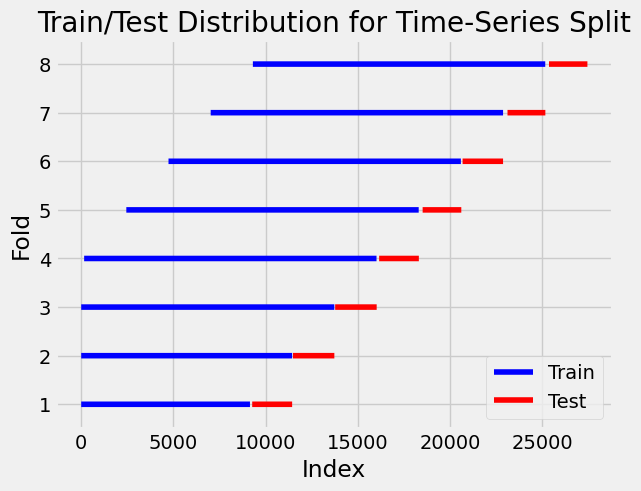

Total confident object score: 0.6109149277688604
Total number of confident objects 6230
Total number of profitable objects: 1382
Scores: [-8159.999999999994, -1704.9999999999998, 1830.0000000000064, 1317.5000000000034, 5697.499999999999, 7410.000000000008, 11870.0, 4115.000000000007]


In [31]:
train_test = "fold"         # fold - train and validate data on TSS fold scheme
                            # inference - train model on all available data and save it
                            # test - test model in production on the new data
if "max_train_size" in params:
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

# set high and low bound for model predictions
# p > high_bound -> 1, p < low_bound -> 0
if "high_bound" in params:
    high_bound = params["high_bound"]
    del params["high_bound"]
    del params["low_bound"]
low_bound = 0

# add object weights
if "sample_weight" in params:
    sample_weight = params["sample_weight"]
    del params["sample_weight"]

if sample_weight == "cos":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
    train_df["weight"] = np.cos(train_df["weight"])
    sample_weight = True
elif sample_weight == "linear":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min())
    sample_weight = True


params["objective"] = "binary"
params["verbosity"] = -1
if params["boosting_type"] != "goss":
    params["subsample_freq"] = 1
else:
    params["subsample"] = None
    params["subsample_freq"] = None
params["importance_type"] = "gain"
params["metric"] = "average_precison"

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=["result", "backtest_result", "oof_conf_score", 
                                                "profit_objects", "oof_conf_obj_num", "scores"])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=750)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values("value", ascending=False)
    df_optuna.to_csv(f"optuna/optuna_lgbm.csv", index=False)

    display(df_optuna.head(10))
elif train_test == "fold":
    model, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight, 
                                                                      n_folds=CFG.n_folds, low_bound=low_bound, 
                                                                      high_bound=high_bound, train_test="fold", 
                                                                      max_train_size=max_train_size, verbose=True)
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)

    print(80 * "=")
    print(f"Total confident object score: {oof_conf_score}\n"
          f"Total number of confident objects {oof_conf_obj_num}\n"
          f"Total number of profitable objects: {round((2 * oof_conf_score - 1) * oof_conf_obj_num)}")
    
    scores = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    print(f"Scores: {scores}")
elif train_test == "inference": 
    model, _, _, _, _ = model_train(train_df, features, params, sample_weight, 
                                    n_folds=8, low_bound=low_bound, 
                                    high_bound=high_bound, train_test="inference", 
                                    max_train_size=max_train_size, verbose=False)
    joblib.dump(model, f"model/lgbm.pkl")
    # save feature dictionary for further inference
    with open(f"model/features.json", "w") as f:
        json.dump(feature_dict, f)

### Test result of the new model against the result of the old model

In [32]:
# TSS fold scores with sample weight
a =  [385.00000000000085, -3110.0000000000036, -8865.0, -979.9999999999998, 7229.999999999995, -17095.0, 23465.000000000007, 16540.000000000007]
# TSS fold scores with threshold 0.5
b =  [1955.0, 54.999999999998074, -315.0, -210.0, 2364.9999999999995, 6645.0, 10680.0, -3554.9999999999995]

ttest_rel(b, a, alternative="greater")

TtestResult(statistic=0.001327825300438882, pvalue=0.49948879878281016, df=7)

### Visualize train results

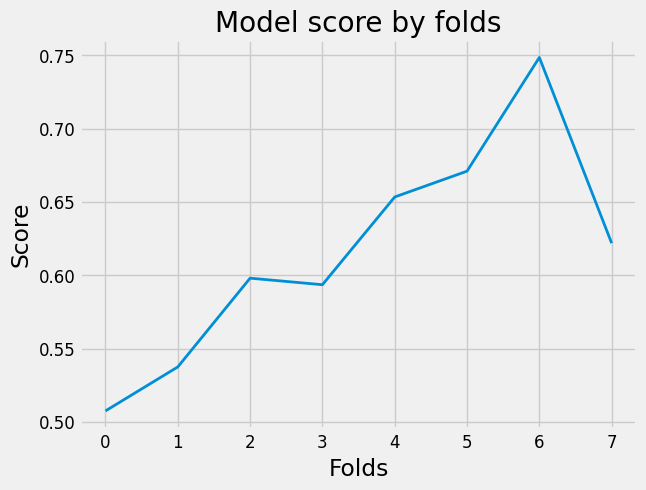

In [33]:
if not CFG.optimize and train_test == "fold":
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores, linewidth=2)

    plt.title("Model score by folds")
    plt.xlabel("Folds")
    plt.xticks(fontsize=12)
    plt.ylabel("Score")
    plt.yticks(fontsize=12)

    plt.show()

### Backtest model

I don't consider funding fees because the can be both positive and negative. I can do it because typical funding fee is positive and majority of my trade are shorts, so I can even earn on funding. But I think it's better not to consider it at all.


  0%|          | 0/6220 [00:00<?, ?it/s]

Result balance increase is 10343.1%


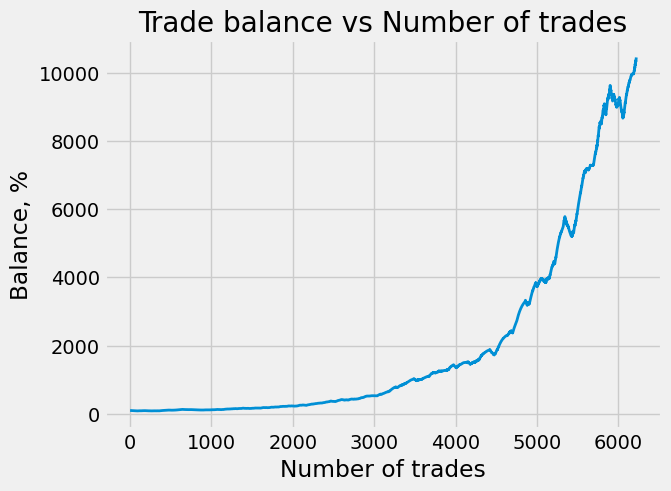

In [34]:
if not CFG.optimize and train_test == "fold":
    result, backtest_df = backtest(train_df, oof, val_idxs, high_bound, show_progress=True, 
                                max_num_simult_trades=CFG.max_num_simult_trades)
        
    # plot the balance
    backtest_plot = backtest_df["balance"].reset_index(drop=True)
    backtest_plot = backtest_plot * 100

    print(f"Result balance increase is {round(result, 3)}%")

    plt.xlabel('Number of trades')
    plt.ylabel('Balance, %')
    plt.title('Trade balance vs Number of trades')
    backtest_plot.plot(linewidth=2);

### Display PR curve for fold predictions

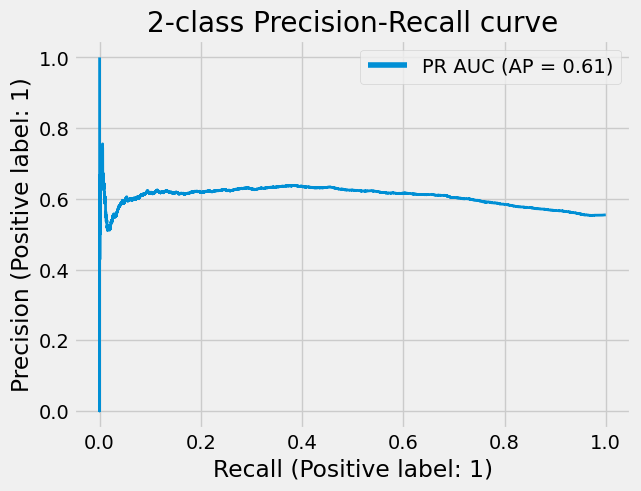

In [35]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == "fold":
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc="upper right")
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold for fold predictions

ic| bound: 0.41
    score: 0.5889
    obj_num: 7587
    obj_pct: 0.73
    obj_profit: 1349
ic| bound: 0.411
    score: 0.58919
    obj_num: 7568
    obj_pct: 0.73
    obj_profit: 1350
ic| bound: 0.412
    score: 0.59
    obj_num: 7539
    obj_pct: 0.73
    obj_profit: 1357
ic| bound: 0.413
    score: 0.59055
    obj_num: 7510
    obj_pct: 0.72
    obj_profit: 1360
ic| bound: 0.414
    score: 0.59062
    obj_num: 7487
    obj_pct: 0.72
    obj_profit: 1357
ic| bound: 0.415
    score: 0.59127
    obj_num: 7467
    obj_pct: 0.72
    obj_profit: 1363
ic| bound: 0.416
    score: 0.59065
    obj_num: 7441
    obj_pct: 0.72
    obj_profit: 1349
ic| bound: 0.417
    score: 0.59089
    obj_num: 7421
    obj_pct: 0.71
    obj_profit: 1349
ic| bound: 0.418
    score: 0.5916
    obj_num: 7402
    obj_pct: 0.71
    obj_profit: 1356
ic| bound: 0.419
    score: 0.59138
    obj_num: 7376
    obj_pct: 0.71
    obj_profit: 1348
ic| bound: 0.42
    score: 0.59247
    obj_num: 7359
    obj_pct: 0.71
    o

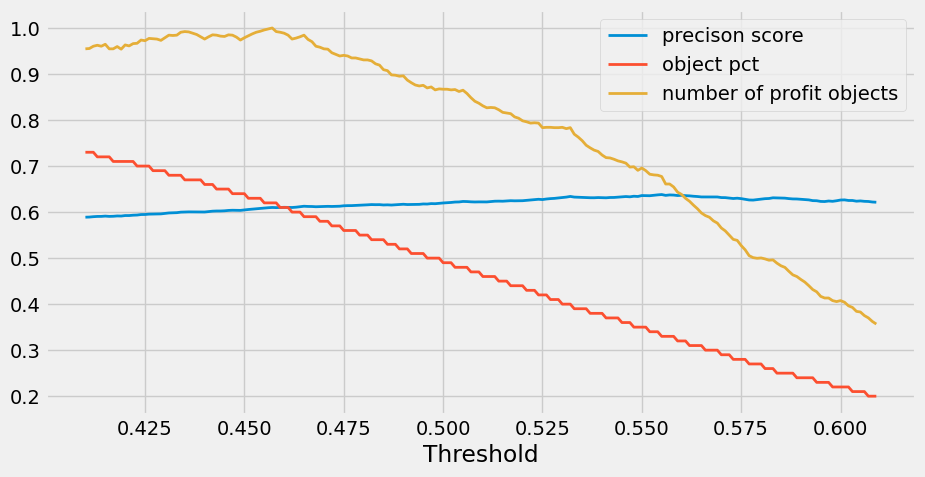

In [36]:
from icecream import ic

if not CFG.optimize and train_test == "fold":
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label="precison score", linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label="object pct", linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label="number of profit objects", linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

### Model feature importance

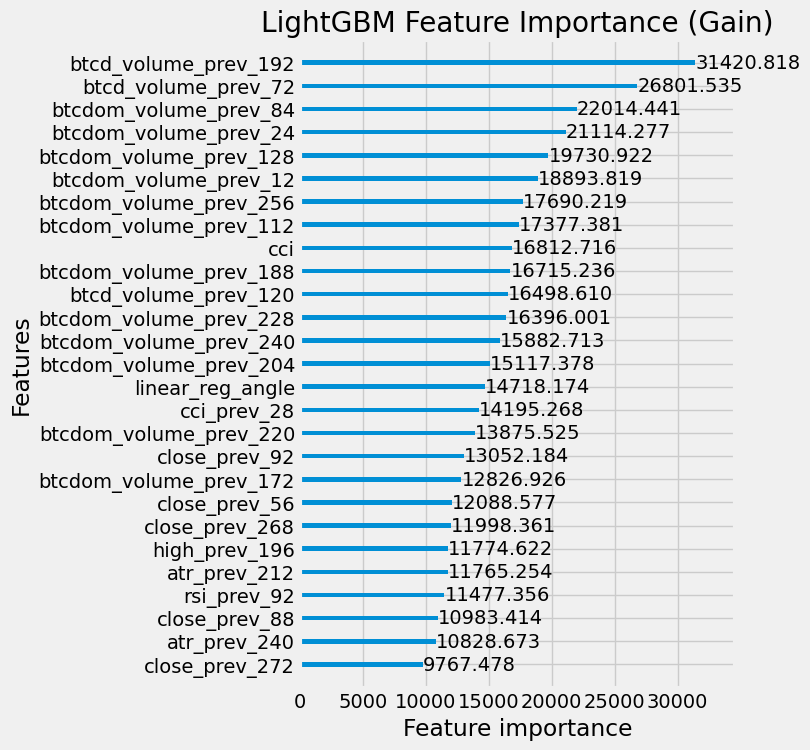

In [37]:
if not CFG.optimize and train_test == "fold":
    lgb.plot_importance(model, importance_type="gain", figsize=(5, 8), title="LightGBM Feature Importance (Gain)")
    plt.show()

# Error analysis

### Distribution of model pseudo-residuals

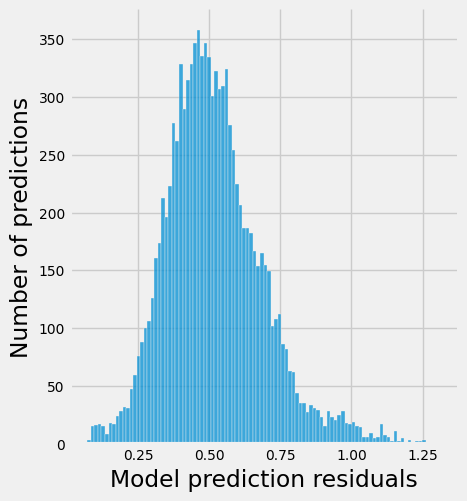

In [38]:
def logloss(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """LogLoss terms"""
    if (y_pred <= 0).any() or (y_pred >= 1).any():
        raise ValueError("y_pred must be between 0 and 1")
    if ((y_true != 0) & (y_true != 1)).any():
        raise ValueError("y_true must be 0 or 1")
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    return y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)


if not CFG.optimize and train_test == "fold":
    residual_df = train_df.loc[val_idxs, ["target"]]
    residual_df["pred"] = oof.ravel()
    y_true = residual_df["target"].values
    y_pred = residual_df["pred"].values
    residuals = -logloss(y_true, y_pred)
    residual_df["residuals"] = residuals
    
    sns.displot(np.log1p(residuals), bins=100)

    plt.xlabel("Model prediction residuals")
    plt.xticks(fontsize=10)
    plt.ylabel("Number of predictions")
    plt.yticks(fontsize=10)

### Pseudo-residuals vs Predictions plot

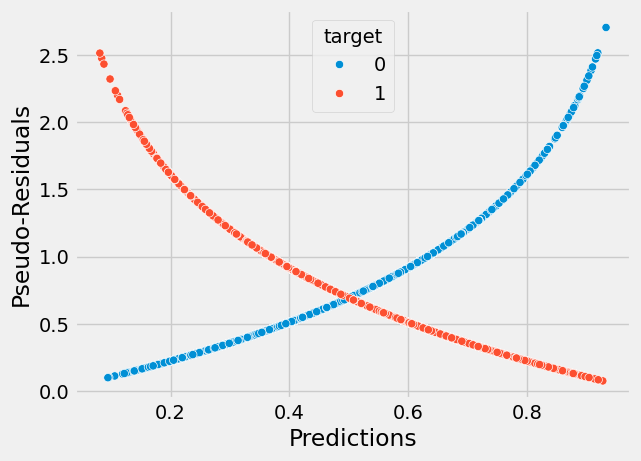

In [39]:
if not CFG.optimize and train_test == "fold":
    sns.scatterplot(residual_df, x="pred", y="residuals", hue="target")
    plt.xlabel("Predictions")
    plt.ylabel("Pseudo-Residuals");

### Residual stat tests

In [40]:
from stat_tests import test_normality, test_unbiased, test_homoscedasticity

if not CFG.optimize and train_test == "fold":
    display(test_normality(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is not normal
    display(test_unbiased(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is biased
    display(test_homoscedasticity(y_true, y_pred, bins=30, alpha=0.05)) # p-value < 0.05 -> residuals distribution is heteroscedastic

p-value may not be accurate for N > 5000.


(0.0, True)

(6.011998604493704e-35, True)

(0.0, True)

### Show worst predictions

In [41]:
if not CFG.optimize and train_test == "fold":
    worst_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(10).index
    worst_idxs_df = train_df.loc[worst_idxs, ["time", "ticker", "target", "ttype"]]
    worst_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(10)["pred"]
    worst_idxs_df

### Show best predictions

In [42]:
if not CFG.optimize and train_test == "fold":
    best_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals").head(10).index
    best_idxs_df = train_df.loc[best_idxs, ["time", "ticker", "target", "ttype"]]
    best_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals").head(10)["pred"]
    best_idxs_df

# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- ticker price doesn't reach the cls_target_ratio_tp or cls_target_ratio_sl thresholds yet

- errors in the data preparation pipeline make model give different predictions

- bot was used in debug mode

- too small volume

- ticker is not presented in bybit_ticker_list due to errors

- ticker was added to exchange not too much time ago

- different high_bound threshold

- there are NaNs in the ticker dataframe

- signal was one of the last in the dataframe and was deleted due to signal error protection measures

In [43]:
if not CFG.optimize:
    if train_test == "test":
        model = joblib.load("model/lgbm.pkl")
        with open(f"model/features.json", "r") as f:
            features = json.load(f)["features"]

    with open(f"model/bybit_tickers.json", "r") as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df["ticker"].isin(bybit_tickers))]
    X["pred"] = model.predict_proba(X[features])[:,1]
    res = X.loc[((X["pred"] >= high_bound)) & (X["time"] > CFG.last_date), ["time", "ticker", "ttype", "pred", "target", "pattern"]]
    res = cap_max_num_simult_trades(res, CFG.max_num_simult_trades)
    res = res.reset_index(drop=True)
    display(res["time"].min(), res["time"].max())
    display(res["target"].value_counts())
    display(res["target"].value_counts(normalize=True))
    display(res[["time", "ticker", "ttype", "pred", "target"]].tail(50))

Timestamp('2024-09-20 23:00:00')

Timestamp('2024-10-17 03:00:00')

0    298
1    205
Name: target, dtype: int64

0    0.592445
1    0.407555
Name: target, dtype: float64

,time,ticker,ttype,pred,target
453,2024-10-14 14:00:00,KDAUSDT,sell,0.668682,0
454,2024-10-14 14:00:00,METISUSDT,sell,0.634229,1
455,2024-10-14 17:00:00,APEUSDT,sell,0.695447,0
456,2024-10-14 17:00:00,ILVUSDT,sell,0.590463,0
457,2024-10-14 17:00:00,RUNEUSDT,sell,0.538652,0
458,2024-10-14 17:00:00,1000PEPEUSDT,sell,0.569678,1
459,2024-10-14 17:00:00,1CATUSDT,sell,0.578498,0
460,2024-10-14 17:00:00,SAGAUSDT,sell,0.660230,0
461,2024-10-14 17:00:00,CTSIUSDT,sell,0.654752,0
462,2024-10-14 17:00:00,NTRNUSDT,sell,0.656533,0


### Plot rolling mean precision score of the model predictions for the test data

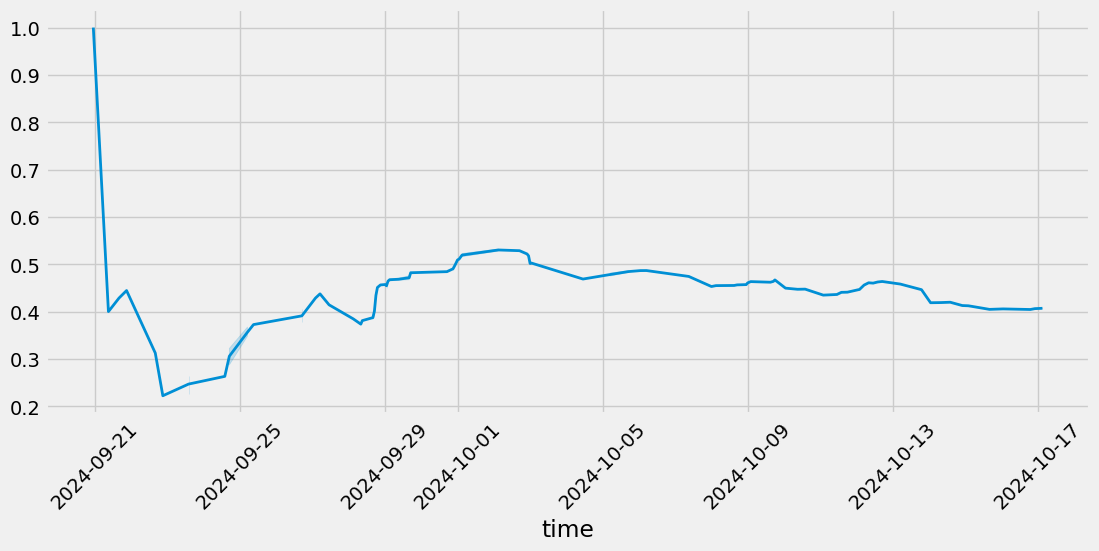

In [44]:
if not CFG.optimize:
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res["target"] == 1]
    
    if len(tmp) > 0:
        tmp["ppv_npv_acc"] = tmp["target"].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

        ax = sns.lineplot(x=tmp["time"], y=tmp["ppv_npv_acc"].values)
        ax.lines[0].set_linewidth(2)
        plt.xticks(rotation=45);

### Show model uncertainty on test data

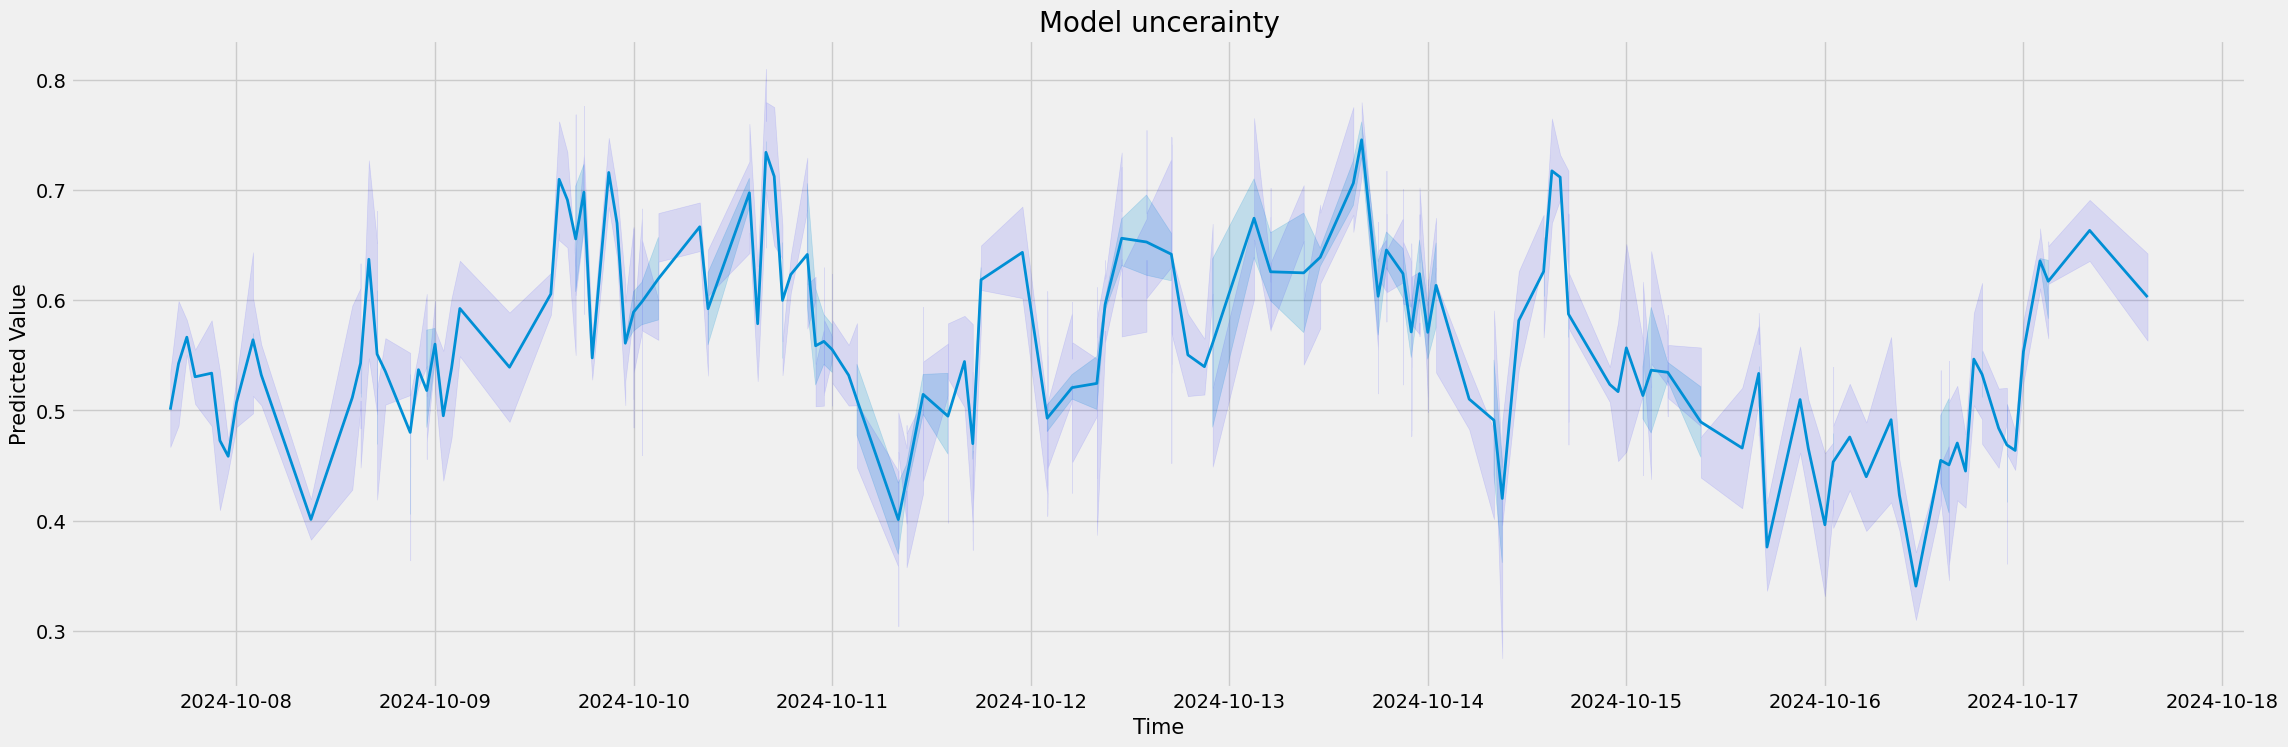

In [45]:
from boosting_uncertainty import predict_with_uncertainty

mask = train_df["time"] >= train_df["time"].max() - pd.to_timedelta(10, unit="d")
prediction_dict = predict_with_uncertainty(model, train_df.loc[mask, features], k=20)

ticker = train_df.loc[mask, "ticker"]
time = train_df.loc[mask, "time"]

pred = prediction_dict.pred_virt#[mask]
lcb = prediction_dict.lcb#[mask]
ucb = prediction_dict.ucb#[mask]

plt.figure(figsize=(25, 8))
plt.title("Model uncerainty", fontsize=20)
sns.lineplot(x=time, y=pred, linewidth=2)
plt.fill_between(time, lcb, ucb, color='b', alpha=.1)
plt.xlabel("Time", fontsize=15)
plt.ylabel("Predicted Value", fontsize=15);

# Compare indicator / signal values for bot and optimizer

In [46]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = "sell"
# ticker = "BADGERUSDT"
# month = 7
# day = 15
# hour = 23
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)
# y = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, "", "", 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, "", "", 0)

# # cols = ["time", "open", "high", "low", "close", "volume", "rsi", "stoch_slowk", "stoch_slowd", "linear_reg", "linear_reg_angle", "macd", "macdsignal", "macdhist"]
# cols = ["time", "open", "high", "low", "close", "volume", "linear_reg", "linear_reg_angle", "high_max", "low_min", "volume_24"]

# higher_features = ["time_4h", "linear_reg", "linear_reg_angle", "macd", "macdhist",  "macd_dir", 
#                    "macdsignal", "macdsignal_dir"]
# x["time"] = pd.to_datetime(x["time"])
# y["time"] = pd.to_datetime(y["time"])
# y["time_4h"] = y["time"] + pd.to_timedelta(3, unit="h")
# x[["time"] + higher_features] = pd.merge(x[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# # x = x.drop(columns=["time_4h"])
# # y = y.drop(columns=["time_4h"])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
# v = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, "", "", 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, "", "", 0)
# z.tail(48)

# v["time_4h"] = v["time"] + pd.to_timedelta(3, unit="h")
# z[["time"] + higher_features] = pd.merge(z[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# z = z.drop(columns=["time_4h"])
# v = v.drop(columns=["time_4h"])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols])